In [1]:
#imports
import spacy
from spacy.lang.en import English
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import sklearn
import string
from spacy.lang.en.stop_words import STOP_WORDS

In [2]:
data_path = '../data/training_test_data/'
data = pd.read_csv(data_path + 'after_stock_data_cleaned.csv')
colnames = ['headline','source','label']   
data.columns = colnames

data2 = pd.read_csv(data_path + 'now_data_parsed.csv')

data2.columns = ['headline','label']

#getting data we have labeled out of the unlabeled data

data2_labeled = pd.concat([data2[438:2438], data2[6448:8448],data2[12458:14458],data2[18468:20709],data2[24478:26479]], sort=False)

data2_labeled.head()

,headline,label
438,amazon opens preorders for cinderella annivers...,1
439,google researchers add attention to augment co...,1
440,android q the choice of the final name for goo...,1
441,google to phase out works with nestprogram in ...,1
442,google announces major android auto update wit...,1


In [3]:
#concatenate our data to their data

from sklearn.utils import shuffle

data = pd.DataFrame({'headline':data['headline'], 'label':data['label']}, columns=['headline', 'label'])

df_union = shuffle(pd.concat([data, data2_labeled], sort=False))

df_union.head()

,headline,label
1915,Behind the Jonas Brothers’ Emotional New Docum...,1
18629,doordarshan begins selling merchandise on amaz...,1
1508,The new Oculus Quest VR headset has become an ...,1
12467,android alert google chrome users need to be a...,1
834,Big U.S. hedge funds regain ardor for FAANGs i...,0


In [4]:
#preprocessing
nlp = English()

spacy_stopwords = STOP_WORDS
punct = string.punctuation
    
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    try:
        text = unidecode.unidecode(text)
    except:
        pass
    return text.strip().lower()

def tokenizer_spacy(headline):
        #filtered_tokenized.append(df_union.at[i, 'headline'])
        #filtered_tokenized.append(row)

    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(str(headline))
    
    #lemmatization improved model
    
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop wordsspacy_stopwords
    return [ str(word).lower().strip() for word in mytokens if str(word).lower().strip() not in spacy_stopwords and str(word).lower().strip() not in punct ]

    # return preprocessed list of tokens
    

In [5]:
###SVD dimensionality reduction
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=5, random_state=None, tol=0.0)

In [6]:
bow_vector = CountVectorizer(tokenizer = tokenizer_spacy, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = tokenizer_spacy)

In [7]:
from sklearn.model_selection import train_test_split

X = df_union['headline'] # the features we want to analyze
y = df_union['label'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('cleaner', <__main__.predictors object at 0x0000025658146080>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
      ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [9]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print("Logistic Regression f1:",metrics.f1_score(y_test, predicted))

Logistic Regression Accuracy: 0.8790976383503701
Logistic Regression Precision: 0.8967412642324303
Logistic Regression Recall: 0.9661590524534687
Logistic Regression f1: 0.9301567908776216


In [10]:
error_analysis = pd.DataFrame(X_test.copy())
error_analysis['actual_classification'] = y_test
error_analysis['logistic_regression_classification'] = predicted

In [11]:
from xgboost import XGBClassifier

clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)

text = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('selector', svd),
                 ('classifier', clf)])

text.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('cleaner', <__main__.predictors object at 0x0000025658977630>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
      ...alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2, silent=None,
       subsample=0.7, verbosity=1))])

In [12]:
predicted = text.predict(X_test)

# Model Accuracy
print("XGBoost Accuracy:",metrics.accuracy_score(y_test, predicted))
print("XGBoost Precision:",metrics.precision_score(y_test, predicted))
print("XGBoost Recall:",metrics.recall_score(y_test, predicted))
print("XGBoost f1:",metrics.f1_score(y_test, predicted))

XGBoost Accuracy: 0.8790976383503701
XGBoost Precision: 0.8903051371185786
XGBoost Recall: 0.9750423011844331
XGBoost f1: 0.9307490409852615


In [13]:
error_analysis['xgboost_classification'] = predicted
error_analysis.to_csv(r"C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\output_data\error_analysis.csv")
#error_analysis.head()

In [14]:
#plot confusion matrices

from sklearn.metrics import confusion_matrix

confusion_matrix(error_analysis['actual_classification'], error_analysis['logistic_regression_classification'])


array([[ 210,  263],
       [  80, 2284]], dtype=int64)

In [15]:
confusion_matrix(error_analysis['actual_classification'], error_analysis['xgboost_classification'])

array([[ 189,  284],
       [  59, 2305]], dtype=int64)

ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

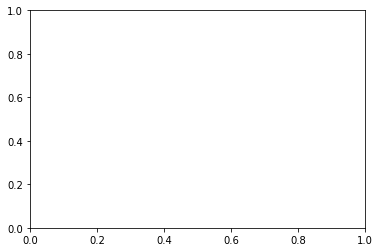

In [17]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
# plot single tree
plot_tree(clf)
plt.show()